In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import random

In [2]:
gpu_ids = []
device_names = []
if torch.cuda.is_available():
    for gpu_id in range(torch.cuda.device_count()):
        gpu_ids += [gpu_id]
        device_names += [torch.cuda.get_device_name(gpu_id)]
print(gpu_ids)
print(device_names)

if len(gpu_ids) > 1:
    device = 'cuda:' + str(gpu_ids[0])  # 여기서 gpu 번호 고르기
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

[0]
['NVIDIA GeForce RTX 3080']
cuda


In [3]:
points, labels = make_moons(n_samples=(1000,1000), shuffle=True ,noise=0.1)

In [4]:
points_l = np.array((
    (-0.9, 0.25),
    (0.4, 1.05),
    (0.9, 0.05),
    # (0.2, 0.3),
    (0.7, -0.4),
    (0.85, -0.35),
    (1.9, 0.2)
))
labels_l = np.array((0,0,0,1,1,1))

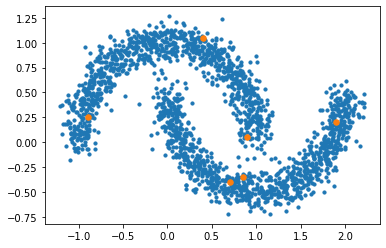

In [5]:
plt.scatter(points[:,0],points[:,1], s=10)
plt.scatter(points_l[:,0],points_l[:,1], s=30)

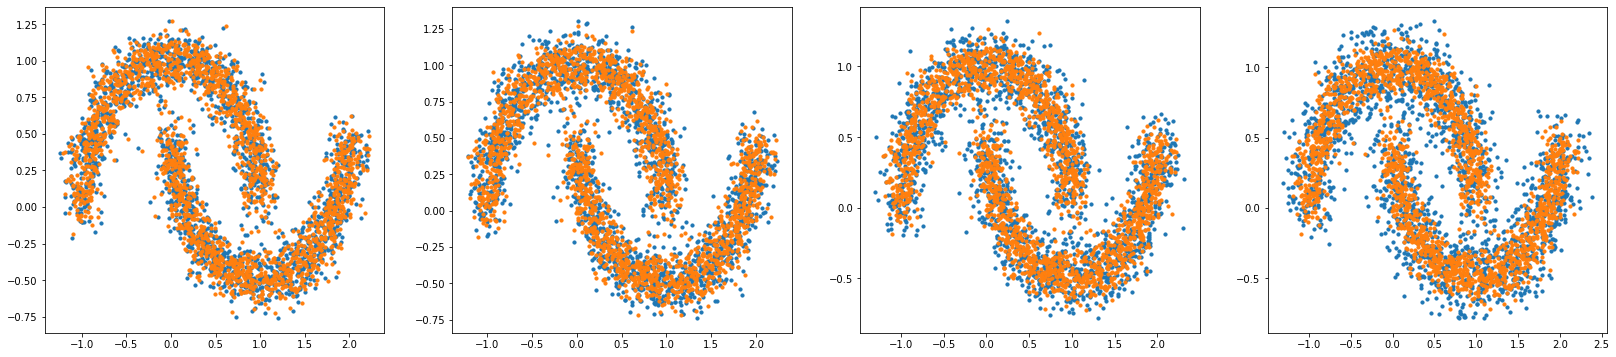

In [6]:
gridshape = (1,4)
marker_size = 0.1

loc = (0,0)
ax = plt.subplot2grid(gridshape, loc)
point_noise = points + (torch.rand(size=points.shape).numpy()-0.5) * 0.1
plt.scatter(point_noise[:,0],point_noise[:,1], s=10)
plt.scatter(points[:,0],points[:,1], s=10)

loc = (0,1)
ax = plt.subplot2grid(gridshape, loc)
point_noise = points + (torch.rand(size=points.shape).numpy()-0.5) * 0.2
plt.scatter(point_noise[:,0],point_noise[:,1], s=10)
plt.scatter(points[:,0],points[:,1], s=10)

loc = (0,2)
ax = plt.subplot2grid(gridshape, loc)
point_noise = points + (torch.rand(size=points.shape).numpy()-0.5) * 0.3
plt.scatter(point_noise[:,0],point_noise[:,1], s=10)
plt.scatter(points[:,0],points[:,1], s=10)

loc = (0,3)
ax = plt.subplot2grid(gridshape, loc)
point_noise = points + (torch.rand(size=points.shape).numpy()-0.5) * 0.4
plt.scatter(point_noise[:,0],point_noise[:,1], s=10)
plt.scatter(points[:,0],points[:,1], s=10)

ax.figure.set(figwidth=28, figheight=6)
plt.show()

In [7]:
class TMClassifier(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=8),
            nn.Sigmoid(),
            nn.Linear(in_features=8, out_features=8),
            nn.Sigmoid(),
            nn.Linear(in_features=8, out_features=2)
        )

        self.init_weight()

    def init_weight(self):
        for layer in self.layers:
            if(isinstance(layer, nn.Linear)):
                nn.init.uniform_(layer.weight, -0.1, 0.1)

    def forward(self, x):
        return self.layers(x)

In [8]:
supervised = TMClassifier().to(device=device)
pseudoLabel = TMClassifier().to(device=device)
metaPseudoLabel = TMClassifier().to(device=device)
lr = 0.1
opt_s = torch.optim.SGD(supervised.parameters(), lr=lr)
opt_pl = torch.optim.SGD(pseudoLabel.parameters(), lr=lr)
opt_mpl = torch.optim.SGD(metaPseudoLabel.parameters(), lr=lr)

In [9]:
creterion = nn.CrossEntropyLoss()

In [10]:
class MyDataset(Dataset):
    def __init__(self, x_data, y_data, transform=None):
        self.x_data = x_data
        self.y_data = y_data
        self.transform = transform
        self.len = len(y_data)
    
    def __getitem__(self, index):
        sample = self.x_data[index], self.y_data[index]
        
        if self.transform:
            sample = self.transform(sample)   #self.transform이 None이 아니라면 전처리
        return sample 
    
    def __len__(self):
        return self.len

In [11]:
labeledData = MyDataset(points_l, labels_l)
unlabeledData = MyDataset(points, labels)

labeledLoader = DataLoader(labeledData, batch_size=6, shuffle=True)
unlabeledLoader = DataLoader(unlabeledData, batch_size=512, shuffle=True)

In [12]:
epoch = 0
max_epoch = 5e3 + 1

In [13]:
while(epoch < max_epoch):
    for point, label in labeledLoader:
        opt_s.zero_grad()

        output = supervised(point.float().to(device))

        loss = creterion(output.cpu(), label.long())

        loss.backward()
        opt_s.step()

    if(epoch%1e3 == 0):
        _, preds = torch.max(output, 1)
        acc = torch.sum(preds.cpu() == label)

        print(f'Epoch: {epoch} \tLoss: {loss.item():.4f} \tAcc: {acc.item()}')
    
    epoch += 1

Epoch: 0 	Loss: 0.6945 	Acc: 3
Epoch: 1000 	Loss: 0.6929 	Acc: 4
Epoch: 2000 	Loss: 0.6915 	Acc: 5
Epoch: 3000 	Loss: 0.3803 	Acc: 5
Epoch: 4000 	Loss: 0.0470 	Acc: 6
Epoch: 5000 	Loss: 0.0119 	Acc: 6


In [14]:
epoch = 0
max_epoch = 5e3 + 1

while(epoch < max_epoch):
    for point, label in unlabeledLoader:
        point_noise = point + (torch.rand(size=point.shape).numpy()-0.5) * 0.4
        opt_pl.zero_grad()

        output_t = supervised(point.float().to(device))
        soft_pseudo_label = torch.softmax(output_t.detach(), dim=-1)
        _, hard_pseudo_label = torch.max(soft_pseudo_label, dim=-1)
        output = pseudoLabel(point_noise.float().to(device))

        loss = creterion(output, soft_pseudo_label)
        # loss = creterion(output, hard_pseudo_label)

        loss.backward()
        opt_pl.step()

    if(epoch%1e3 == 0):
        _, preds = torch.max(output, 1)
        acc = torch.sum(preds == label.to(device))

        print(f'Epoch: {epoch} \tLoss: {loss.item():.4f} \tAcc: {acc.item()} / {point.shape[0]}')
    
    epoch += 1

Epoch: 0 	Loss: 0.6484 	Acc: 241 / 464
Epoch: 1000 	Loss: 0.1003 	Acc: 375 / 464
Epoch: 2000 	Loss: 0.0985 	Acc: 374 / 464
Epoch: 3000 	Loss: 0.1151 	Acc: 388 / 464
Epoch: 4000 	Loss: 0.0939 	Acc: 383 / 464
Epoch: 5000 	Loss: 0.0887 	Acc: 387 / 464


In [15]:
x = np.linspace(-1.5, 2.5, num=1000)
y = np.linspace(-1.5, 1.5, num=1000)

X,Y = np.meshgrid(x,y)

# plt.scatter(X, Y)

In [16]:
arr = np.stack((X.flatten(),Y.flatten()),axis=1)

In [17]:
renderData = MyDataset(arr, np.zeros_like(arr))

renderLoader = DataLoader(renderData, batch_size=1024, shuffle=False, drop_last=False)

In [18]:
s_preds = np.array([])
pl_preds = np.array([])

for point, _ in renderLoader:
    # print(point)
    _, s_pred = torch.max(supervised(point.float().to(device)), 1)
    _, pl_pred = torch.max(pseudoLabel(point.float().to(device)), 1)
    # break

    s_preds = np.concatenate((s_preds,s_pred.cpu().numpy()))
    pl_preds = np.concatenate((pl_preds,pl_pred.cpu().numpy()))

In [19]:
print(arr.shape, s_preds.shape, pl_preds.shape)

(1000000, 2) (1000000,) (1000000,)


In [20]:
s_pred_points_0 = []
s_pred_points_1 = []
pl_pred_points_0 = []
pl_pred_points_1 = []

for i in range(arr.shape[0]):
    if(s_preds[i] == 0):
        s_pred_points_0.append(arr[i])
    else:
        s_pred_points_1.append(arr[i])
    if(pl_preds[i] == 0):
        pl_pred_points_0.append(arr[i])
    else:
        pl_pred_points_1.append(arr[i])

print(len(s_pred_points_0),len(s_pred_points_1))
print(len(pl_pred_points_0),len(pl_pred_points_1))

600584 399416
601309 398691


In [21]:
np.array(s_pred_points_0).shape

(600584, 2)

[None, None]

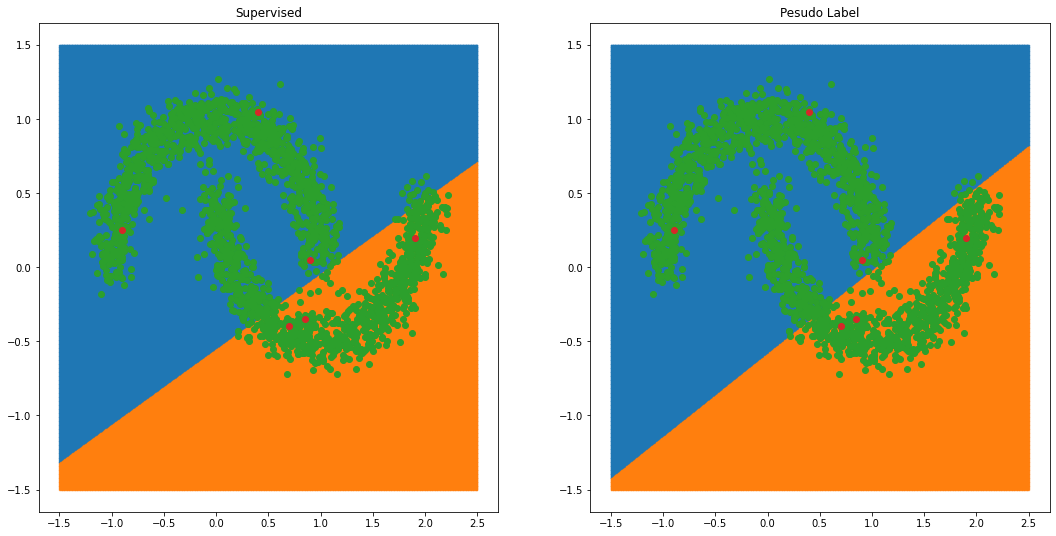

In [22]:
gridshape = (1, 3)
marker_size = 0.1

loc = (0,0)
ax = plt.subplot2grid(gridshape, loc)

plt.scatter(np.array(s_pred_points_0)[:,0], np.array(s_pred_points_0)[:,1], s=marker_size)
plt.scatter(np.array(s_pred_points_1)[:,0], np.array(s_pred_points_1)[:,1], s=marker_size)
plt.scatter(points[:,0],points[:,1])
plt.scatter(points_l[:,0],points_l[:,1])
plt.title('Supervised')

loc = (0,1)
ax = plt.subplot2grid(gridshape, loc)

plt.scatter(np.array(pl_pred_points_0)[:,0], np.array(pl_pred_points_0)[:,1], s=marker_size)
plt.scatter(np.array(pl_pred_points_1)[:,0], np.array(pl_pred_points_1)[:,1], s=marker_size)
plt.scatter(points[:,0],points[:,1])
plt.scatter(points_l[:,0],points_l[:,1])
plt.title('Pesudo Label')

ax.figure.set(figwidth=28, figheight=9)

In [23]:
supervised_mpl = TMClassifier().to(device=device)
lr = 0.1
opt_st = torch.optim.SGD(supervised_mpl.parameters(), lr=lr)

In [24]:
for i in range(len(supervised_mpl.layers)):
    if(isinstance(supervised_mpl.layers[i], nn.Linear)):
        supervised_mpl.layers[i].weight = supervised.layers[i].weight
        supervised_mpl.layers[i].bias = supervised.layers[i].bias

In [25]:
epoch = 0
max_epoch = 2e4+1

threshold = 0.6
lambda_u = 8

points_l_tensor = torch.tensor(points_l, device=device)
labels_l_tensor = torch.tensor(labels_l, dtype=torch.long, device=device)

In [26]:
while(epoch < max_epoch):
    for point, label in unlabeledLoader:
        # concatenate unlabeled data and labeled data for efficiency
        batch_size = point.shape[0]
        point_noise = point + (torch.rand(size=point.shape).numpy()-0.5) * 0.4
        points_ = torch.concat((point.to(device), point_noise.to(device), points_l_tensor)).float()
        
        opt_mpl.zero_grad()
        opt_st.zero_grad()
        
        # run teacher model
        output_t = supervised_mpl(points_)

        output_t_uo = output_t[:batch_size] # unlabeled original
        output_t_ua = output_t[batch_size:batch_size*2] # unlabeled augmented
        output_t_l = output_t[batch_size*2:] # labeled
        del output_t
        
        loss_t_supervised = creterion(output_t_l, labels_l_tensor)

        # get pseudo_label & compute uda loss
        # soft_pseudo_label = torch.softmax(output_t_uo.detach(), dim=-1)
        soft_pseudo_label = torch.softmax(output_t_uo.detach() / 0.7, dim=-1) # args.temperture
        max_probs, hard_pseudo_label = torch.max(soft_pseudo_label, dim=-1)
        mask = max_probs.ge(threshold).float()
        weight_u = lambda_u * min(1., (epoch + 1) / 500.)
        # loss_t_u = torch.mean(-(soft_pseudo_label * torch.log_softmax(output_t_ua, dim=-1)).sum(dim=-1)) # consistency loss
        loss_t_u = torch.mean(-(soft_pseudo_label * torch.log_softmax(output_t_ua, dim=-1)).sum(dim=-1) * mask) # consistency loss
        # loss_t_uda = loss_t_supervised + loss_t_u
        # loss_t_uda = loss_t_supervised + loss_t_u * lambda_u
        loss_t_uda = loss_t_supervised + loss_t_u * weight_u

        # run student model
        output = metaPseudoLabel(points_)

        # output_uo = output[:batch_size]
        output_ua = output[batch_size:batch_size*2]
        output_l = output[batch_size*2:]
        del output

        # student is trained with augmented data 
        # https://github.com/google-research/google-research/issues/534#issuecomment-769559165

        # store old loss of student on labeled data
        loss_old = nn.functional.cross_entropy(output_l.detach(), labels_l_tensor)

        loss = creterion(output_ua, hard_pseudo_label)    # get loss of student on unlabeled augmented input using pseudo label
        # loss = creterion(output_uo, hard_pseudo_label)    # get loss of student on unlabeled original input using pseudo label

        # update student
        loss.backward(retain_graph=True)
        opt_mpl.step()
        
        with torch.no_grad():
            out_new_l = metaPseudoLabel(points_[batch_size*2:])
        loss_new = nn.functional.cross_entropy(out_new_l.detach(), labels_l_tensor)

        # compute dot product(h) using first order Taylor series
        # f(a+h) - f(a) = f'(a)h
        # h = loss_old - loss_new # theoretically (https://github.com/kekmodel/MPL-pytorch/issues/6)
        h = loss_new - loss_old # official code

        # compute teacher loss
        _, hard_pseudo_label = torch.max(output_t_ua.detach(), dim=-1)
        loss_t_mpl = h * nn.functional.cross_entropy(output_t_ua, hard_pseudo_label)
        # _, hard_pseudo_label = torch.max(output_t_uo, dim=-1)
        # loss_t_mpl = h * nn.functional.cross_entropy(output_t_uo, hard_pseudo_label)

        loss_t = loss_t_mpl + loss_t_uda
        loss_t.backward()
        opt_st.step()

    if(epoch%1e3 == 0):
        _, preds = torch.max(output_t_uo, dim=-1)
        acc = torch.sum(preds == label.to(device))

        print(f'Epoch: {epoch} \tLoss: {loss.item():.4f} \tAcc: {acc.item()} / {point.shape[0]}')
    
    epoch += 1

Epoch: 0 	Loss: 0.6555 	Acc: 378 / 464
Epoch: 1000 	Loss: 0.1003 	Acc: 370 / 464
Epoch: 2000 	Loss: 0.1047 	Acc: 382 / 464
Epoch: 3000 	Loss: 0.0792 	Acc: 384 / 464
Epoch: 4000 	Loss: 0.0733 	Acc: 377 / 464
Epoch: 5000 	Loss: 0.0767 	Acc: 391 / 464
Epoch: 6000 	Loss: 0.0607 	Acc: 379 / 464
Epoch: 7000 	Loss: 0.0737 	Acc: 379 / 464
Epoch: 8000 	Loss: 0.0785 	Acc: 384 / 464
Epoch: 9000 	Loss: 0.0618 	Acc: 388 / 464
Epoch: 10000 	Loss: 0.0870 	Acc: 370 / 464
Epoch: 11000 	Loss: 0.0486 	Acc: 382 / 464
Epoch: 12000 	Loss: 0.0682 	Acc: 380 / 464
Epoch: 13000 	Loss: 0.0556 	Acc: 387 / 464
Epoch: 14000 	Loss: 0.0685 	Acc: 401 / 464
Epoch: 15000 	Loss: 0.0942 	Acc: 384 / 464
Epoch: 16000 	Loss: 0.0493 	Acc: 378 / 464
Epoch: 17000 	Loss: 0.0624 	Acc: 386 / 464
Epoch: 18000 	Loss: 0.0571 	Acc: 391 / 464
Epoch: 19000 	Loss: 0.0793 	Acc: 387 / 464
Epoch: 20000 	Loss: 0.0908 	Acc: 376 / 464


In [27]:
print(loss_t_u)
print(mask)
print(torch.sum(mask))
print(loss_t_uda)
print(loss_old)
print(loss_new)
print(h)
print(loss_t_mpl)
print(loss_t)

tensor(0.1017, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,

In [28]:
s_mpl_preds = np.array([])
mpl_preds = np.array([])

for point, _ in renderLoader:
    _, s_mpl_pred = torch.max(supervised_mpl(point.float().to(device)), 1)
    _, mpl_pred = torch.max(metaPseudoLabel(point.float().to(device)), dim=-1)

    s_mpl_preds = np.concatenate((s_mpl_preds,s_mpl_pred.cpu().numpy()))
    mpl_preds = np.concatenate((mpl_preds,mpl_pred.cpu().numpy()))

In [29]:
s_mpl_pred_points_0 = []
s_mpl_pred_points_1 = []
mpl_pred_points_0 = []
mpl_pred_points_1 = []

for i in range(arr.shape[0]):
    if(s_mpl_preds[i] == 0):
        s_mpl_pred_points_0.append(arr[i])
    else:
        s_mpl_pred_points_1.append(arr[i])
    if(mpl_preds[i] == 0):
        mpl_pred_points_0.append(arr[i])
    else:
        mpl_pred_points_1.append(arr[i])

print(len(s_mpl_pred_points_0),len(s_mpl_pred_points_1))
print(len(mpl_pred_points_0),len(mpl_pred_points_1))

600584 399416
631835 368165


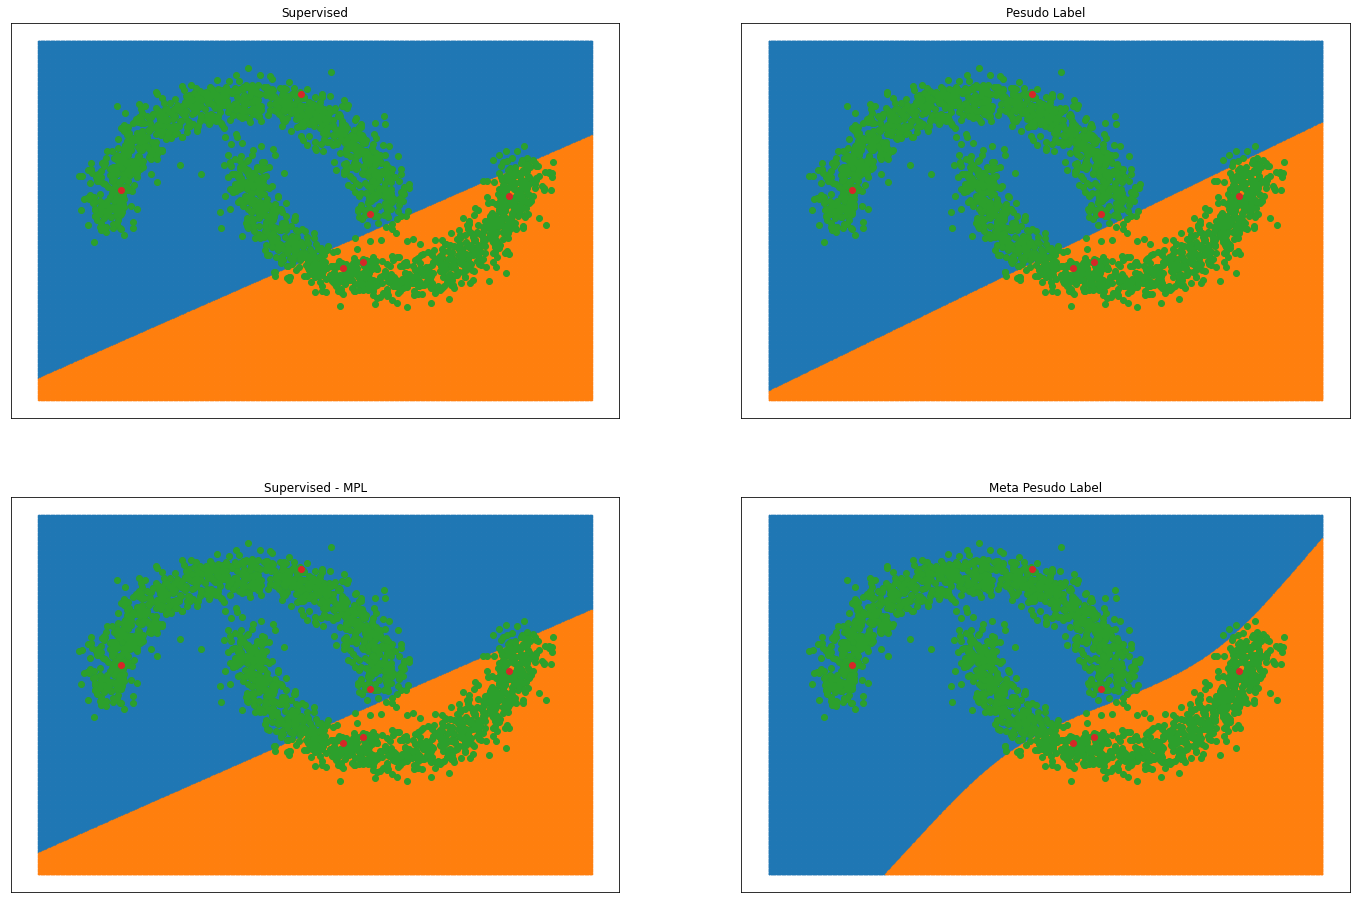

In [30]:
gridshape = (2, 2)
marker_size = 0.1

loc = (0,0)
ax = plt.subplot2grid(gridshape, loc)
ax.set_xticks([])
ax.set_yticks([])

plt.scatter(np.array(s_pred_points_0)[:,0], np.array(s_pred_points_0)[:,1], s=marker_size)
plt.scatter(np.array(s_pred_points_1)[:,0], np.array(s_pred_points_1)[:,1], s=marker_size)
plt.scatter(points[:,0],points[:,1])
plt.scatter(points_l[:,0],points_l[:,1])
plt.title('Supervised')

loc = (0,1)
ax = plt.subplot2grid(gridshape, loc)
ax.set_xticks([])
ax.set_yticks([])

plt.scatter(np.array(pl_pred_points_0)[:,0], np.array(pl_pred_points_0)[:,1], s=marker_size)
plt.scatter(np.array(pl_pred_points_1)[:,0], np.array(pl_pred_points_1)[:,1], s=marker_size)
plt.scatter(points[:,0],points[:,1])
plt.scatter(points_l[:,0],points_l[:,1])
plt.title('Pesudo Label')

loc = (1,0)
ax = plt.subplot2grid(gridshape, loc)
ax.set_xticks([])
ax.set_yticks([])

plt.scatter(np.array(s_mpl_pred_points_0)[:,0], np.array(s_mpl_pred_points_0)[:,1], s=marker_size)
plt.scatter(np.array(s_mpl_pred_points_1)[:,0], np.array(s_mpl_pred_points_1)[:,1], s=marker_size)
plt.scatter(points[:,0],points[:,1])
plt.scatter(points_l[:,0],points_l[:,1])
plt.title('Supervised - MPL')

loc = (1,1)
ax = plt.subplot2grid(gridshape, loc)
ax.set_xticks([])
ax.set_yticks([])

plt.scatter(np.array(mpl_pred_points_0)[:,0], np.array(mpl_pred_points_0)[:,1], s=marker_size)
plt.scatter(np.array(mpl_pred_points_1)[:,0], np.array(mpl_pred_points_1)[:,1], s=marker_size)
plt.scatter(points[:,0],points[:,1])
plt.scatter(points_l[:,0],points_l[:,1])
plt.title('Meta Pesudo Label')

ax.figure.set(figwidth=24, figheight=16)

plt.show()

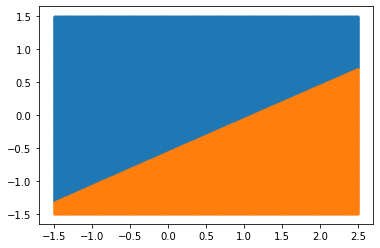

In [31]:
plt.scatter(np.array(s_mpl_pred_points_0)[:,0], np.array(s_mpl_pred_points_0)[:,1], s=marker_size)
plt.scatter(np.array(s_mpl_pred_points_1)[:,0], np.array(s_mpl_pred_points_1)[:,1], s=marker_size)

In [32]:
max_epoch = 3e5 + 1

In [33]:
while(epoch < max_epoch):
    for point, label in unlabeledLoader:
        # concatenate unlabeled data and labeled data for efficiency
        batch_size = point.shape[0]
        point_noise = point + (torch.rand(size=point.shape).numpy()-0.5) * 0.4
        points_ = torch.concat((point.to(device), point_noise.to(device), points_l_tensor)).float()
        
        opt_mpl.zero_grad()
        opt_st.zero_grad()
        
        # run teacher model
        output_t = supervised_mpl(points_)

        output_t_uo = output_t[:batch_size] # unlabeled original
        output_t_ua = output_t[batch_size:batch_size*2] # unlabeled augmented
        output_t_l = output_t[batch_size*2:] # labeled
        del output_t
        
        loss_t_supervised = creterion(output_t_l, labels_l_tensor)

        # get pseudo_label & compute uda loss
        # soft_pseudo_label = torch.softmax(output_t_uo.detach(), dim=-1)
        soft_pseudo_label = torch.softmax(output_t_uo.detach() / 0.7, dim=-1) # args.temperture
        max_probs, hard_pseudo_label = torch.max(soft_pseudo_label, dim=-1)
        mask = max_probs.ge(threshold).float()
        weight_u = lambda_u * min(1., (epoch + 1) / 500.)
        # loss_t_u = torch.mean(-(soft_pseudo_label * torch.log_softmax(output_t_ua, dim=-1)).sum(dim=-1)) # consistency loss
        loss_t_u = torch.mean(-(soft_pseudo_label * torch.log_softmax(output_t_ua, dim=-1)).sum(dim=-1) * mask) # consistency loss
        # loss_t_uda = loss_t_supervised + loss_t_u
        # loss_t_uda = loss_t_supervised + loss_t_u * lambda_u
        loss_t_uda = loss_t_supervised + loss_t_u * weight_u

        # run student model
        output = metaPseudoLabel(points_)

        # output_uo = output[:batch_size]
        output_ua = output[batch_size:batch_size*2]
        output_l = output[batch_size*2:]
        del output

        # student is trained with augmented data 
        # https://github.com/google-research/google-research/issues/534#issuecomment-769559165

        # store old loss of student on labeled data
        loss_old = nn.functional.cross_entropy(output_l.detach(), labels_l_tensor)

        loss = creterion(output_ua, hard_pseudo_label)    # get loss of student on unlabeled augmented input using pseudo label
        # loss = creterion(output_uo, hard_pseudo_label)    # get loss of student on unlabeled original input using pseudo label

        # update student
        loss.backward(retain_graph=True)
        opt_mpl.step()
        
        with torch.no_grad():
            out_new_l = metaPseudoLabel(points_[batch_size*2:])
        loss_new = nn.functional.cross_entropy(out_new_l.detach(), labels_l_tensor)

        # compute dot product(h) using first order Taylor series
        # f(a+h) - f(a) = f'(a)h
        # h = loss_old - loss_new # theoretically (https://github.com/kekmodel/MPL-pytorch/issues/6)
        h = loss_new - loss_old # official code

        # compute teacher loss
        _, hard_pseudo_label = torch.max(output_t_ua.detach(), dim=-1)
        loss_t_mpl = h * nn.functional.cross_entropy(output_t_ua, hard_pseudo_label)
        # _, hard_pseudo_label = torch.max(output_t_uo, dim=-1)
        # loss_t_mpl = h * nn.functional.cross_entropy(output_t_uo, hard_pseudo_label)

        loss_t = loss_t_mpl + loss_t_uda
        loss_t.backward()
        opt_st.step()

    if(epoch%1e3 == 0):
        _, preds = torch.max(output_t_uo, dim=-1)
        acc = torch.sum(preds == label.to(device))

        print(f'Epoch: {epoch} \tLoss: {loss.item():.4f} \tAcc: {acc.item()} / {point.shape[0]}')
    
    if(epoch%2e4 == 0):
        s_mpl_preds = np.array([])
        mpl_preds = np.array([])

        for point, _ in renderLoader:
            _, s_mpl_pred = torch.max(supervised_mpl(point.float().to(device)), 1)
            _, mpl_pred = torch.max(metaPseudoLabel(point.float().to(device)), dim=-1)

            s_mpl_preds = np.concatenate((s_mpl_preds,s_mpl_pred.cpu().numpy()))
            mpl_preds = np.concatenate((mpl_preds,mpl_pred.cpu().numpy()))

        s_mpl_pred_points_0 = []
        s_mpl_pred_points_1 = []
        mpl_pred_points_0 = []
        mpl_pred_points_1 = []

        for i in range(arr.shape[0]):
            if(s_mpl_preds[i] == 0):
                s_mpl_pred_points_0.append(arr[i])
            else:
                s_mpl_pred_points_1.append(arr[i])
            if(mpl_preds[i] == 0):
                mpl_pred_points_0.append(arr[i])
            else:
                mpl_pred_points_1.append(arr[i])

                gridshape = (2, 2)
        
        gridshape = (1,2)

        loc = (0,0)
        ax = plt.subplot2grid(gridshape, loc)
        ax.set_xticks([])
        ax.set_yticks([])

        plt.scatter(np.array(s_mpl_pred_points_0)[:,0], np.array(s_mpl_pred_points_0)[:,1], s=marker_size)
        plt.scatter(np.array(s_mpl_pred_points_1)[:,0], np.array(s_mpl_pred_points_1)[:,1], s=marker_size)
        plt.scatter(points[:,0],points[:,1])
        plt.scatter(points_l[:,0],points_l[:,1])
        plt.title('Supervised - MPL')

        loc = (0,1)
        ax = plt.subplot2grid(gridshape, loc)
        ax.set_xticks([])
        ax.set_yticks([])

        plt.scatter(np.array(mpl_pred_points_0)[:,0], np.array(mpl_pred_points_0)[:,1], s=marker_size)
        plt.scatter(np.array(mpl_pred_points_1)[:,0], np.array(mpl_pred_points_1)[:,1], s=marker_size)
        plt.scatter(points[:,0],points[:,1])
        plt.scatter(points_l[:,0],points_l[:,1])
        plt.title('Meta Pesudo Label')

        ax.figure.set(figwidth=14, figheight=6)

        plt.show()

    epoch += 1

Epoch: 21000 	Loss: 0.0764 	Acc: 378 / 464
Epoch: 22000 	Loss: 0.0572 	Acc: 386 / 464
Epoch: 23000 	Loss: 0.0695 	Acc: 377 / 464
Epoch: 24000 	Loss: 0.0778 	Acc: 389 / 464
Epoch: 25000 	Loss: 0.0690 	Acc: 391 / 464
Epoch: 26000 	Loss: 0.0953 	Acc: 383 / 464
Epoch: 27000 	Loss: 0.0659 	Acc: 392 / 464
Epoch: 28000 	Loss: 0.0574 	Acc: 395 / 464
Epoch: 29000 	Loss: 0.0494 	Acc: 400 / 464
Epoch: 30000 	Loss: 0.0688 	Acc: 379 / 464
Epoch: 31000 	Loss: 0.0796 	Acc: 381 / 464
Epoch: 32000 	Loss: 0.0600 	Acc: 395 / 464
Epoch: 33000 	Loss: 0.0686 	Acc: 375 / 464
Epoch: 34000 	Loss: 0.0498 	Acc: 386 / 464
Epoch: 35000 	Loss: 0.0605 	Acc: 380 / 464
Epoch: 36000 	Loss: 0.0854 	Acc: 392 / 464
Epoch: 37000 	Loss: 0.0793 	Acc: 379 / 464
Epoch: 38000 	Loss: 0.0818 	Acc: 380 / 464
Epoch: 39000 	Loss: 0.0673 	Acc: 379 / 464
Epoch: 40000 	Loss: 0.0899 	Acc: 385 / 464
Epoch: 41000 	Loss: 0.0726 	Acc: 374 / 464
Epoch: 42000 	Loss: 0.0588 	Acc: 392 / 464
Epoch: 43000 	Loss: 0.0878 	Acc: 386 / 464
Epoch: 4400

In [34]:
s_mpl_preds = np.array([])
mpl_preds = np.array([])

for point, _ in renderLoader:
    _, s_mpl_pred = torch.max(supervised_mpl(point.float().to(device)), 1)
    _, mpl_pred = torch.max(metaPseudoLabel(point.float().to(device)), dim=-1)

    s_mpl_preds = np.concatenate((s_mpl_preds,s_mpl_pred.cpu().numpy()))
    mpl_preds = np.concatenate((mpl_preds,mpl_pred.cpu().numpy()))

In [35]:
s_mpl_pred_points_0 = []
s_mpl_pred_points_1 = []
mpl_pred_points_0 = []
mpl_pred_points_1 = []

for i in range(arr.shape[0]):
    if(s_mpl_preds[i] == 0):
        s_mpl_pred_points_0.append(arr[i])
    else:
        s_mpl_pred_points_1.append(arr[i])
    if(mpl_preds[i] == 0):
        mpl_pred_points_0.append(arr[i])
    else:
        mpl_pred_points_1.append(arr[i])

print(len(s_mpl_pred_points_0),len(s_mpl_pred_points_1))
print(len(mpl_pred_points_0),len(mpl_pred_points_1))

600584 399416
588852 411148


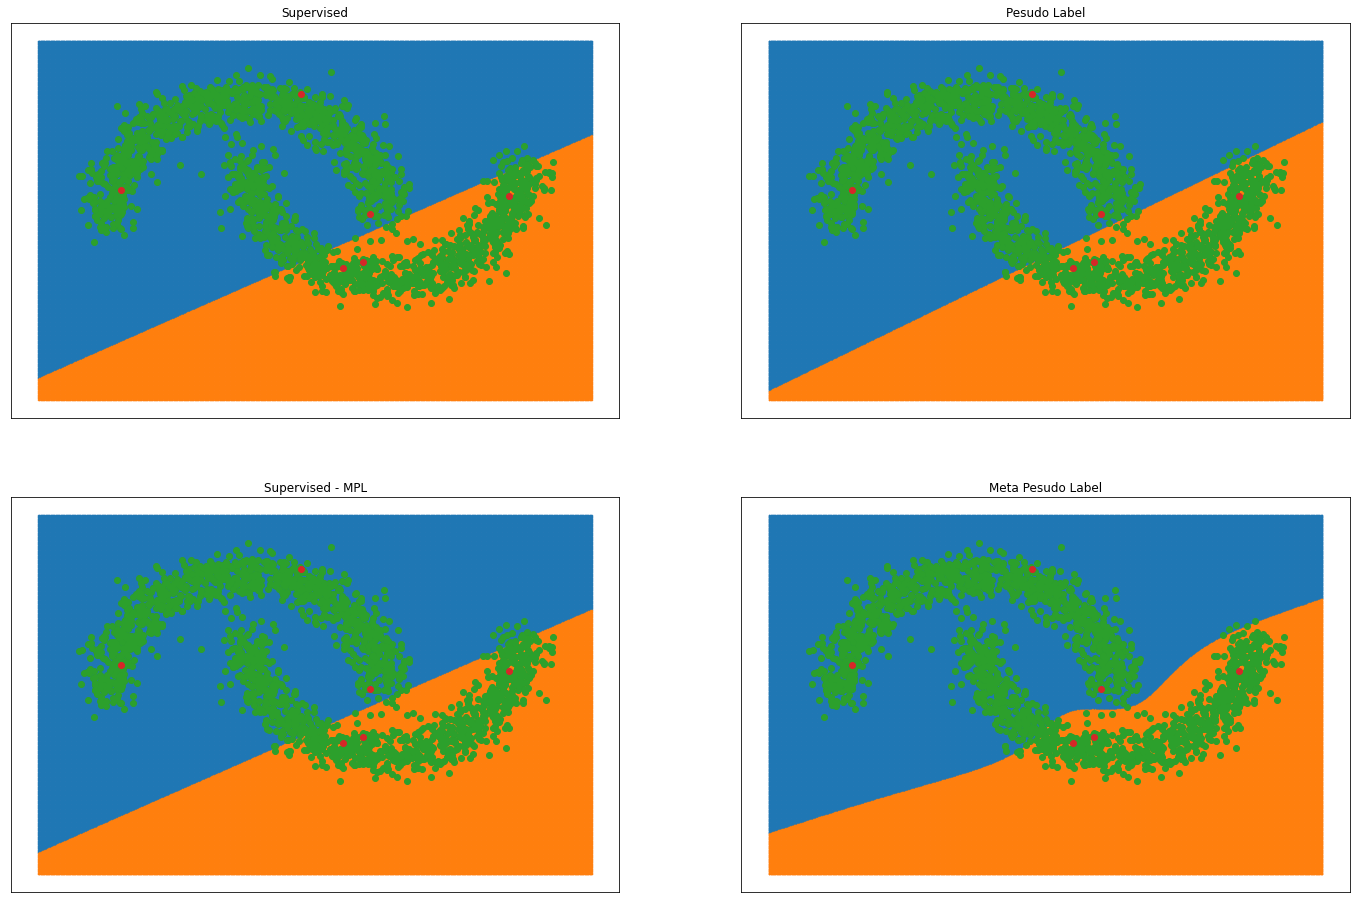

In [36]:
gridshape = (2, 2)
marker_size = 0.1

loc = (0,0)
ax = plt.subplot2grid(gridshape, loc)
ax.set_xticks([])
ax.set_yticks([])

plt.scatter(np.array(s_pred_points_0)[:,0], np.array(s_pred_points_0)[:,1], s=marker_size)
plt.scatter(np.array(s_pred_points_1)[:,0], np.array(s_pred_points_1)[:,1], s=marker_size)
plt.scatter(points[:,0],points[:,1])
plt.scatter(points_l[:,0],points_l[:,1])
plt.title('Supervised')

loc = (0,1)
ax = plt.subplot2grid(gridshape, loc)
ax.set_xticks([])
ax.set_yticks([])

plt.scatter(np.array(pl_pred_points_0)[:,0], np.array(pl_pred_points_0)[:,1], s=marker_size)
plt.scatter(np.array(pl_pred_points_1)[:,0], np.array(pl_pred_points_1)[:,1], s=marker_size)
plt.scatter(points[:,0],points[:,1])
plt.scatter(points_l[:,0],points_l[:,1])
plt.title('Pesudo Label')

loc = (1,0)
ax = plt.subplot2grid(gridshape, loc)
ax.set_xticks([])
ax.set_yticks([])

plt.scatter(np.array(s_mpl_pred_points_0)[:,0], np.array(s_mpl_pred_points_0)[:,1], s=marker_size)
plt.scatter(np.array(s_mpl_pred_points_1)[:,0], np.array(s_mpl_pred_points_1)[:,1], s=marker_size)
plt.scatter(points[:,0],points[:,1])
plt.scatter(points_l[:,0],points_l[:,1])
plt.title('Supervised - MPL')

loc = (1,1)
ax = plt.subplot2grid(gridshape, loc)
ax.set_xticks([])
ax.set_yticks([])

plt.scatter(np.array(mpl_pred_points_0)[:,0], np.array(mpl_pred_points_0)[:,1], s=marker_size)
plt.scatter(np.array(mpl_pred_points_1)[:,0], np.array(mpl_pred_points_1)[:,1], s=marker_size)
plt.scatter(points[:,0],points[:,1])
plt.scatter(points_l[:,0],points_l[:,1])
plt.title('Meta Pesudo Label')

ax.figure.set(figwidth=24, figheight=16)

plt.show()